In [ ]:
%load_ext autoreload
%autoreload 2

import astropy
import galsim
import matplotlib.pyplot as plt
import numpy as np
import scarlet
import sep

import btk

In [ ]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 100.2
max_number = 60
batch_size = 1
max_shift = 44
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("LSST")
seed=3

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, maxshift=max_shift, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [ ]:
blend = next(draw_generator)

Generating blends for LSST survey:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
field_images = blend["blend_images"]
isolated_images = blend["isolated_images"]

In [ ]:
def compute_pixel_covariance_and_flux(predicted_galaxy, simulated_galaxy, field_image):
    ground_truth_pixels = []
    predicted_pixels = []
    sig = []
    
    actual_flux = []
    predicted_flux = []

    for band_number in range(len(bands)):
        sig.append(sep.Background(field_image[band_number]).globalrms)
        # print(sig)
        # print(sig[band_number])
        mask1 = simulated_galaxy[band_number]>0 * sig[band_number]
        mask2 = predicted_galaxy[band_number]>0 * sig[band_number]
        mask = np.logical_or(mask1, mask2)
#             fig, ax = plt.subplots(1, 2)
#             plt.subplot(1,2,1)
#             plt.imshow(cutout_galaxy[:, :, band_number])
#             plt.subplot(1, 2, 2)
#             plt.imshow(madness_predictions[blend_number][galaxy_number][band_number])
#             plt.show()
        ground_truth_pixels.extend(simulated_galaxy[band_number][mask])
        predicted_pixels.extend(predicted_galaxy[band_number][mask])
        
        actual_flux.append(np.sum(simulated_galaxy[band_number][mask1]))
        predicted_flux.append(np.sum(predicted_galaxy[band_number][mask2]))
                              
    pixel_covariance = np.sum(np.multiply(predicted_pixels, ground_truth_pixels))/(np.sqrt(np.sum(np.square(predicted_pixels)))*np.sqrt(np.sum(np.square(ground_truth_pixels))))

    return pixel_covariance, actual_flux, predicted_flux

# Deblend with Scarlet

In [ ]:
np.shape(field_images)

(1, 6, 501, 501)

In [ ]:
psf = np.array([p.drawImage(galsim.Image(field_images[0].shape[1],field_images[0].shape[2]),scale=survey.pixel_scale.to_value("arcsec")).array for p in blend["psf"]])
bands=[f for f in survey._filters]
wcs = blend["wcs"]

In [ ]:
import scarlet.psf
from scarlet.psf import ImagePSF

In [ ]:
def predict_with_scarlet(image, x_pos, y_pos, show_scene, show_sources, filters):
    sig = []
    weights = np.ones_like(image)
    for i in range(6):
        sig.append(sep.Background(image[i]).globalrms)
        weights[i] = weights[i] / (sig[i]**2)
    observation = scarlet.Observation(
            image, psf=scarlet.psf.ImagePSF(psf), weights= weights, channels=bands, wcs=wcs
        )
    
    model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(filters))
    model_frame = scarlet.Frame(
    image.shape,
    psf=model_psf,
    channels=filters, wcs=wcs)

    
    observation = observation.match(model_frame)
    sources = []
    for i in range(len(x_pos)):
        result = scarlet.ExtendedSource(
            model_frame,
            model_frame.get_sky_coord((x_pos[i], y_pos[i])),
            observation,
            thresh=1,
            shifting=True,
        )
        sources.append(result)

    scarlet.initialization.set_spectra_to_match(sources, observation)
    
    scarlet_blend = scarlet.Blend(sources, observation)
    
    %time it, logL = scarlet_blend.fit(200, e_rel=1e-5)
    #print(f"scarlet ran for {it} iterations to logL = {logL}")
    #scarlet.display.show_likelihood(scarlet_blend)
    #plt.show()
    
    if show_scene:
        scarlet.display.show_scene(sources,
                           norm=None,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
        
        plt.show()
    
    if show_sources:
        scarlet.display.show_sources(sources,
                                 norm=None,
                                 observation=observation,
                                 show_rendered=True,
                                 show_observed=True,
                                 add_boxes=True
                                )
        plt.show()
    
    predicted_sources = []
    for src in sources:
        predicted_sources.append(observation.render(src.get_model(frame=model_frame)))
    #print(np.shape(src.get_model(frame=model_frame)))
    return predicted_sources

In [ ]:
image = field_images[0]

In [ ]:
x_pos = blend['blend_list'][0]['y_peak']
y_pos = blend['blend_list'][0]['x_peak']

In [ ]:
#model = predict_with_scarlet(image, x_pos=x_pos, y_pos=y_pos, show_scene=True, show_sources=True, filters=bands)

In [ ]:
#plt.imshow(model[0][2])

In [ ]:
scarlet_predictions=[]
for i, image in enumerate(field_images):
    image = field_images[i]
    x_pos = blend['blend_list'][i]['y_peak']
    y_pos = blend['blend_list'][i]['x_peak']
    predicted_sources = predict_with_scarlet(image, x_pos=x_pos, y_pos=y_pos, show_scene=False, show_sources=False, filters=bands)
    scarlet_predictions.append(predicted_sources)

CPU times: user 53.6 s, sys: 26.9 s, total: 1min 20s
Wall time: 1min 19s


# Deblend with MADNESS

In [ ]:
import sys 
sys.path.insert(0,'../')
from maddeb.Deblender import Deblend
import tensorflow as tf
import tensorflow_probability as tfp


madness_predictions = []
for i in range(len(blend['blend_list'])):
    blends = blend['blend_list'][i]
    #print(blends)
    detected_positions = []
    for j in range(len(blends)):
        detected_positions.append([blends['y_peak'][j], blends['x_peak'][j]])

    deb = Deblend(field_images[i], 
                  detected_positions,
                  latent_dim=8, 
                  num_components=len(blends), 
                  use_likelihood=True, 
                  linear_norm_coeff=80000,
                  max_iter=300)
    #tf.config.run_functions_eagerly(False)
    convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(atol=.0000001*45*45*len(blends)*3, min_num_steps=50, window_size=20)
    #convergence_criterion = None
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=15, decay_rate=0.8, staircase=True)
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler, momentum=0.1)

    deb(convergence_criterion, optimizer=optimizer, use_debvader=True, compute_sig_dynamically=False)
    madness_predictions.append(deb.get_components())
    del(deb)

2022-07-14 03:11:44.901467: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2022-07-14 03:11:44.901532: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-14 03:11:53.341476: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2022-07-14 03:11:53.341558: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-14 03:11:53.341620: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow/python/ops/linalg/linear_operator_lower_triangular.py:151: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_probability/python/distributions/distribution.py:334: calling TransformedDistribution.__init__ (from tensorflow_probability.python.distributions.transformed_distribution) with batch_shape is deprecated and will be removed after 2020-06-01.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_probability/python/distributions/distribution.py:334: calling TransformedDistribution.__init__ (from tensorflow_probability.python.distributions.transformed_distribution) with event_shape is deprecated and will be removed after 2020-06-01.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
2022-07-14 03:12:02.403117: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this m

In [ ]:
np.shape(madness_predictions[0])

(49, 6, 45, 45)

In [ ]:
import sys 
sys.path.insert(0,'../')
from maddeb.extraction import extract_cutouts

In [ ]:
cov_madness = []
madness_actual_flux = []
madness_predicted_flux = []
for blend_number in range(len(field_images)):
    blends_meta_data = blend['blend_list'][blend_number]
    #print(blends)
    
    for galaxy_number in range(len(blends_meta_data)):
        detected_position = [[blends_meta_data['y_peak'][galaxy_number], blends_meta_data['x_peak'][galaxy_number]]]
        distances_to_center = list(
            np.array(detected_position) - int((np.shape(field_images[0])[1] - 1) / 2)
        )
        cutout_galaxy, idx = extract_cutouts(isolated_images[blend_number][galaxy_number], distances_to_center, cutout_size=45)
        #print(idx)
        if idx == [] :
            continue
        cutout_galaxy = cutout_galaxy[0]
        cutout_galaxy = np.transpose(cutout_galaxy, axes=(2, 0, 1))
        #print(np.shape(cutout_galaxy))
        ground_truth_pixels = []
        predicted_pixels = []
        sig = []
#        fig, ax = plt.subplots(1, 2)
#         plt.subplot(1,2,1)
#         plt.imshow(cutout_galaxy[2])
#         plt.subplot(1, 2, 2)
#         plt.imshow(madness_predictions[blend_number][galaxy_number][2])
#         plt.show()
        cov, actual, predicted = compute_pixel_covariance_and_flux(madness_predictions[blend_number][galaxy_number], cutout_galaxy, field_images[0])
        
        cov_madness.append(cov)
        madness_actual_flux.append(actual)
        madness_predicted_flux.append(predicted)

# Compare: Covariance matrix and flux reconstruction

In [ ]:
scarlet_cov = []
scarlet_actual_flux = []
scarlet_predicted_flux = []

for blend_number in range(len(field_images)):

    for galaxy_number in range(len(blend['blend_list'][blend_number])):

        ground_truth_pixels = []
        predicted_pixels = []
        sig = []
        
        current_galaxy = isolated_images[blend_number][galaxy_number]
        cov, actual, predicted = compute_pixel_covariance_and_flux(scarlet_predictions[blend_number][galaxy_number], current_galaxy, field_images[0])
        
        scarlet_cov.append(cov)
        scarlet_actual_flux.append(actual)
        scarlet_predicted_flux.append(predicted)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 48.]),
 array([0.64217245, 0.677922  , 0.71367155, 0.7494211 , 0.78517066,
        0.82092021, 0.85666976, 0.89241931, 0.92816886, 0.96391842,
        0.99966797]),
 <BarContainer object of 10 artists>)

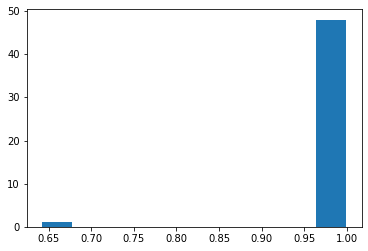

In [ ]:
plt.hist(scarlet_cov)

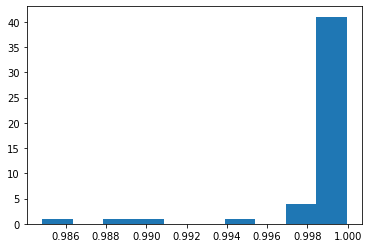

In [ ]:
plt.hist(cov_madness);

In [ ]:
scarlet_actual_flux = np.array(scarlet_actual_flux)
scarlet_predicted_flux = np.array(scarlet_predicted_flux)

scarlet_relative_difference= np.abs(np.divide(scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux))

In [ ]:
madness_actual_flux = np.array(madness_actual_flux)
madness_predicted_flux = np.array(madness_predicted_flux)

madness_relative_difference= np.abs(np.divide(madness_predicted_flux - madness_actual_flux, madness_actual_flux))

Text(0, 0.5, 'number of galaxies')

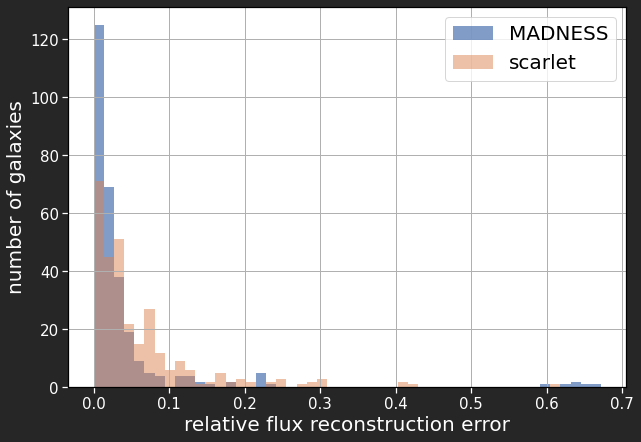

In [ ]:
import seaborn as sns
#print(madness_relative_difference[np.logical_not(np.isinf(madness_relative_difference))].reshape(-1))
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'black',
                     'image.cmap': 'viridis',})
plt.figure(figsize=(10,7))
bins = plt.hist(madness_relative_difference[np.logical_not(np.isnan(madness_relative_difference))].reshape(-1), bins=50, alpha=0.7, label="MADNESS");
plt.hist(scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))].reshape(-1), bins=bins[1], alpha=0.5, label="scarlet");
plt.legend(fontsize=20)
ax=plt.gca()
plt.xlabel("relative flux reconstruction error", fontsize=20)
ax.tick_params(labelsize=15)
plt.ylabel("number of galaxies", fontsize=20)